# ガボールフィルタバンクで特徴量を造る


__目次：__
- <a href="#background">ガボールフィルタの概要</a>
- <a href="#1Dbg">1次元のガボールフィルタ</a>
- <a href="#1Dapp">1Dフィルタの応用</a>
- <a href="#2Dbg">2次元のガボールフィルタ</a>
- <a href="#2Dapp">2Dフィルタの応用</a>

___

<a id="background"></a>
## ガボールフィルタの概要

信号処理の技法には、多数のフィルタが存在するが、ここで科学的な応用のきわめて多いガボールフィルタ（Gabor filter）に着目する。我々の目的は、画像から、多種多様な情報を「特徴量」として取り出し、最終的に控えている予測課題の「入力」として使うことである。詳しい紹介は専門書に委ねるとして、ここでは要点のみ述べることにする。

一言でいえば、ガボールフィルタとは、__ガウス関数で変調される正弦波__である。英語の呼称を使って定式化すると、

\begin{align}
(\text{Filter output}) = (\text{Sinusoid carrier}) \times (\text{Gaussian envelope})
\end{align}

という形式になる。その「次元数」によって1D、2D、3Dと様々なバージョンが文献の上では存在する。下記には2次元のガボールフィルタと、関連する関数のグラフが表されている（Jones et al., 1987）：

<img src="img/ex_gabor_form.png" alt="Image source: Jones et al., 1987" />


応用事例をいくつかピックアップしてみよう。たとえば、動物の受容野のモデリング（DeAngelis et al., 1993）、

<img src="img/ex_receptive_field.png" alt="Image source: DeAngelis et al., 1993" />

テキスチャー・質感の判定（scikit-imageより）、

<img src="img/ex_texture_recognition.png" alt="Image source: scikit-image documentation" />

顔認識（九工大のBIS研より）、

<img src="img/ex_facial_features.jpg" alt="Image source: Kyushu Institute of Technology" />

など、実に多様な応用例がある。我々の実務として重要になってくるのは、下記の事項である：

 - 周波数のパラメータを調整することで、フィルタが「効く」解像度が変わる。
 
 - ガウス関数の半径を大きく・小さくすることで、画像内で効く範囲が拡大・縮小される。
 
 - もっとも単純なガボールフィルタは1Dで、時間の関数として信号を捉えていることから「temporal」と呼ぶ。2次元以上だと、空間「spatial」や時空「spatio-temporal」のバリエーションがある。

フィルタを信号に適用する方法はいくつもあるが、もっとも標準的なのは、畳み込み（convolution）という操作である。対象信号とフィルタ（これもまた信号である）の定義域が共通しているので、畳み込んで新しい信号を造ることができる。表記についてだが、任意の信号$f$と$g$をとって、これらの畳み込みを$f \ast g$と記す。1次元の場合は下記のように定義される。

\begin{align}
(f \ast g)(t) = \int_{\mathbb{R}} f(t)g(t-\tau) \, d\tau
\end{align}

2次元もまったく同様に定義される。

\begin{align}
(f \ast g)(x,y) = \int_{\mathbb{R}^{2}} f(x,y)g(x-\alpha,y-\beta) \, d\alpha\,d\beta.
\end{align}

呼称はいくらでもあり得るが、もし$f$が関心のある入力（ここでは画像内の画素値を返す）で、$g$が我々が設計したフィルタであるとすると、フィルタを応用した結果として得られる応答が$f \ast g$である。

<a id="1Dbg"></a>
## 1次元のガボールフィルタ

概要と良いとして、これから自分でフィルタを設計・実装しようと思えば、もう少し具体的な情報が必要だ。まず、基本的な表記とフィルタの働きを確認するために、1Dの「temporal」ガボールフィルタを作ってみよう。書き方として、

\begin{align}
G(t) = f(t) \, s(t)
\end{align}

とするが、これらのパーツは下記のように定義される。

\begin{align}
s(t) & = \exp \left(i (2\pi ut + \phi) \right)\\
 & = \cos(2\pi ut + \phi) + i\sin(2\pi ut + \phi)\\
f(t) & = A \exp\left( -\frac{t^2}{\sigma^2} \right).
\end{align}

正弦波とガウス関数の効き目をつかさどるパラメータについて：

 - $u$: 周波数。つまり、正弦波が時間1単位あたり、何周するか示す値。例として、$u=1$なら、周期が1（時間、分、秒など）である。周波数を$u=2$と倍にすると、周期が半減して1/2になる（時間1単位あたり、2周もするから）。反対に$u=1/2$ならば、一周するには時間が2単位必要になる。以下同様。
 - $A$: 振幅。フィルタの取る最大値を定める。
 - $\phi$: 位相。定義域において、どこで（時間ならば、いつ）大きく・小さくなるか決める。
 - $\sigma$: ガウス関数の範囲を定める。 $\sigma > 0$が小さいほど、効き目を持つ時間が短くなる。

数式はもう良いとして、そろそろ自分で実装して、ガボールフィルタを動かしてみよう。

In [1]:
import math
import numpy as np


def G_carrier_real(t, freq, phase):
    '''
    Real part of the carrier.
    '''
    topass = 2 * math.pi * freq * t + phase
    out = np.cos(topass)
    return out

def G_carrier_imag(t, freq, phase):
    '''
    Imaginary part of the carrier.
    '''
    topass = 2 * math.pi * freq * t + phase
    out = np.sin(topass)
    return out


def G_envelope(t, amp, sdev):
    '''
    The impact of the filter is controlled by a Gaussian function.
    '''
    out = amp * np.exp( (-(t/sdev)**2) )
    return out


フィルタ自体は、複数のパラメータによって決められる。下記のdictでそれらの値を格納する。

In [2]:

myparas = {"amp": 1/(2*math.pi),
           "sdev": 1,
           "freq": 1,
           "phase": 0}


パラメータを引数として、カスタマイズされたフィルタを下記のように造る。

In [3]:

def G_fil_real(t, paras):
    '''
    Custom-built filter response (real part).
    Assumes that t is an array of temporal inputs.
    '''
    carrier = G_carrier_real(t=t, freq=paras["freq"], phase=paras["phase"])
    envelope = G_envelope(t=t, amp=paras["amp"], sdev=paras["sdev"])
    out = carrier * envelope
    return out

def G_fil_imag(t, paras):
    '''
    Custom-built filter response (imaginary part).
    Assumes that t is an array of temporal inputs.
    '''
    carrier = G_carrier_imag(t=t, freq=paras["freq"], phase=paras["phase"])
    envelope = G_envelope(t=t, amp=paras["amp"], sdev=paras["sdev"])
    out = carrier * envelope
    return out


上記から明らかなように、「正弦波×ガウス関数」という形式が守られている。各要素を可視化してみる。

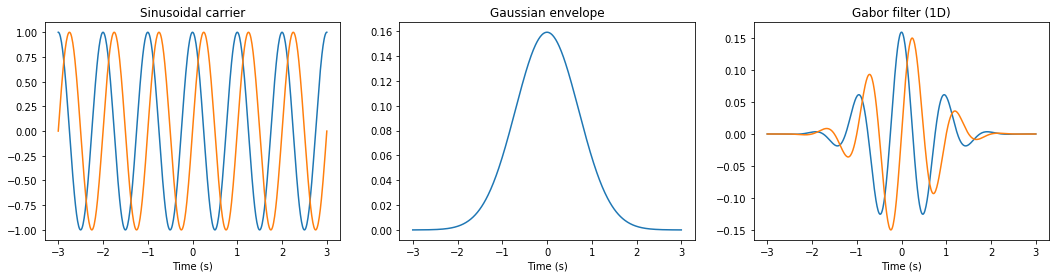

In [4]:
import matplotlib.pyplot as plt

myfig = plt.figure(figsize=(18,4))
t_inputs = np.linspace(-3,3,500)

ax_carrier = myfig.add_subplot(1,3,1)
plt.title("Sinusoidal carrier")
plt.xlabel("Time (s)")
ax_envelope = myfig.add_subplot(1,3,2)
plt.title("Gaussian envelope")
plt.xlabel("Time (s)")
ax_filter = myfig.add_subplot(1,3,3)
plt.title("Gabor filter (1D)")
plt.xlabel("Time (s)")

ax_carrier.plot(t_inputs, G_carrier_real(t=t_inputs, freq=myparas["freq"], phase=myparas["phase"]))
ax_carrier.plot(t_inputs, G_carrier_imag(t=t_inputs, freq=myparas["freq"], phase=myparas["phase"]))

ax_envelope.plot(t_inputs, G_envelope(t=t_inputs, amp=myparas["amp"], sdev=myparas["sdev"]))

ax_filter.plot(t_inputs, G_fil_real(t=t_inputs, paras=myparas))
ax_filter.plot(t_inputs, G_fil_imag(t=t_inputs, paras=myparas))

plt.show()

### 練習問題 (A):

0. `freq`という周波数パラメータに着目する。上左図で正弦波が実際に何周をしているか目視で確かめること。時間1単位あたりの回数が期待通りか。この`freq`を色々な値（例：1、4、0.5、0.25など）に変えて、どう変わるか確認すること。

0. 「標準偏差」の`sdev`パラメータをたとえば0.25や2に変えてみてください。どのようにフィルタの出力が変わるか。もしそのままでは見づらいのであれば、適宜に`t_inputs`の範囲を拡縮してみること。

0. 位相の`phase`に着目し、実部と虚部が一致するように、虚部のほうだけパラメータの値を変えてみてください（$\pi/2$のズレがある）。

___

<a id="1Dapp"></a>
## 1Dフィルタの応用

フィルタ自体は見てきたが、それを応用することとはどういうことか、実践的に調べてみる。まず、わかりやすい例として擬似的な信号を造る。

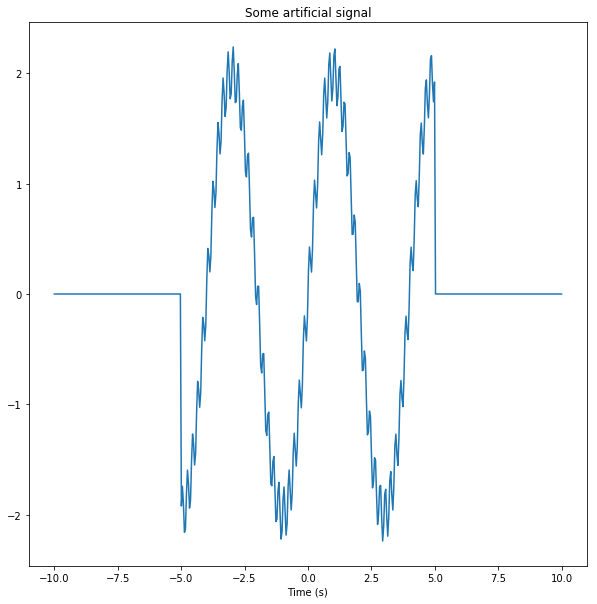

In [5]:

para_HIGHFREQ = 5
para_LOWFREQ = 0.25

def my_signal(t):
    
    highfreq = 0.25 * np.sin((2*math.pi*para_HIGHFREQ*t))
    lowfreq = 2 * np.sin((2*math.pi*para_LOWFREQ*t))
    
    cond = (np.abs(t) <= 5)
    signal = highfreq + lowfreq
    out = np.select([cond], [signal])
    
    return out


myfig = plt.figure(figsize=(10,10))
t_inputs = np.linspace(-10, 10, 500)

plt.plot(t_inputs, my_signal(t=t_inputs))
plt.title("Some artificial signal")
plt.xlabel("Time (s)")
plt.show()

先述のとおり、フィルタを応用する場合は、対象信号との畳み込みを求めることが多い。`scipy`の`signal`モジュールから、`convolve`という関数がここで出番を迎える。

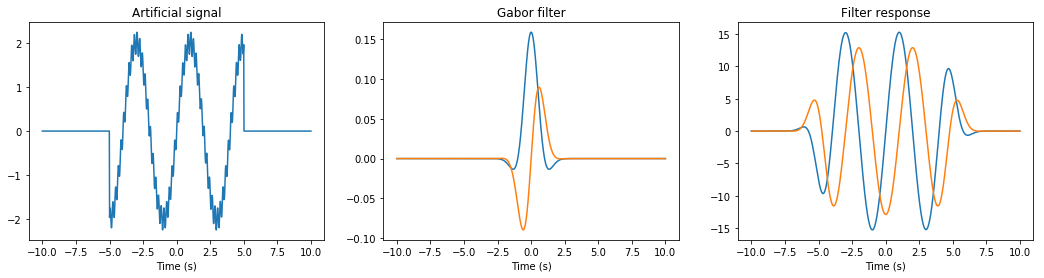

In [6]:
from scipy import signal

t_inputs = np.linspace(-10, 10, 1000)
sig_values = my_signal(t=t_inputs)

myparas = {"amp": 1/(2*math.pi),
           "sdev": 1,
           "freq": 0.25,
           "phase": 0}
fil_values_real = G_fil_real(t=t_inputs, paras=myparas)
fil_values_imag = G_fil_imag(t=t_inputs, paras=myparas)
fil_response_real = signal.convolve(sig_values, fil_values_real, mode="same")
fil_response_imag = signal.convolve(sig_values, fil_values_imag, mode="same")

myfig = plt.figure(figsize=(18,4))

ax_signal = myfig.add_subplot(1,3,1)
plt.title("Artificial signal")
plt.xlabel("Time (s)")
ax_filter = myfig.add_subplot(1,3,2)
plt.title("Gabor filter")
plt.xlabel("Time (s)")
ax_response = myfig.add_subplot(1,3,3)
plt.title("Filter response")
plt.xlabel("Time (s)")

ax_signal.plot(t_inputs, sig_values)

ax_filter.plot(t_inputs, fil_values_real)
ax_filter.plot(t_inputs, fil_values_imag)

ax_response.plot(t_inputs, fil_response_real)
ax_response.plot(t_inputs, fil_response_imag)

plt.show()


### 練習問題 (B):

0. 上のコードを使って、`myparas`に入る`freq`パラメータとして、複数の値を試してみてください。特に、`para_LOWFREQ`〜`para_HIGHFREQ`の範囲内。値が小さいときに低周波数の成分が取り出せること、値が大きいときに高周波数の成分が取り出せることなど、実証的に確かめること。これを示すグラフをいくつか用意して保存すること。

0. 位相と標準偏差のパラメータも、色々といじってみてください。それぞれの大小と、フィルタ出力の変化との関係について説明すること。

0. 擬似信号である`my_signal`を、「低・高」から「低・中・高」に改造すること（つまり、2つではなく、3つの正弦波の線形和にする）。改めてフィルタをかけて、`freq`を適当に設定することで、それぞれの成分が抽出できるか。できるならば、その結果を図示すること。

以上、1次元のガボールフィルタをやや丁寧に見てきた。最終的に使うのは2次元のほうだが、基本的な働きはまったく同じであることから、1次元を先に見て、可視化しておくと2Dバージョンが非常に理解しやすくなるといえる。最大のポイントは、信号の「特徴」を、フィルタの設計の如何によって、好きなように取り出せることである。
___

<a id="2Dbg"></a>
## 2次元のガボールフィルタ

ガボールフィルタの基本的な発想、定式化、そして実務上の働きもある程度は見てきた。これを土台にして、より一般生の高いバージョンを見ていく。基本的な形式は1次元のときとまったく同様で、

\begin{align}
(\text{Filter output}) = (\text{Sinusoid carrier}) \times (\text{Gaussian envelope})
\end{align}

となっている。ただし、「2次元」と呼ぶのは、定義域が「線」から「面」へと拡がるからである。実数値$t \in \mathbb{R}$ではなく、 実数ベクトル$(x,y) \in \mathbb{R}^{2}$をフィルタの引数とする。もう少し改まった形にすると、

\begin{align}
G(x,y) = f(x,y) \, s(x,y)
\end{align}

と書く。正弦波とガウス関数は至って自然な形で拡張される：

\begin{align}
s(x,y) & = \exp \left(i (2\pi (ux + vy) + \phi) \right)\\
 & = \cos(2\pi (ux + vy) + \phi) + i\sin(2\pi (ux + vy) + \phi)\\
f(x,y) & = A \exp\left( -\frac{x^2 + y^2}{\sigma^2} \right).
\end{align}

今回は周波数パラメータ（角周波数）が$u$と$v$と2つあるが、それを極座標に置き換えて調整することが多い。変換は下記のとおりである。

\begin{align}
u & = \omega \cos(\theta) \\
v & = \omega \sin(\theta)
\end{align}

新しく出てきたパラメータが$\omega$（空間周波数）と$\theta$（フィルタの向き）である。以下に補足説明を記す。

- $u$と$v$: 周波数。捉え方としては、画像における「ヨコ」と「タテ」方向にそれぞれは対応する。離散的なデジタル画像だと、空間単位（ピクセル）あたり請願はが何周するか示す数値である。
- $A$: 振幅。1Dと同じ。
- $\phi$: 位相。1Dと同じ。
- $\sigma$: 標準偏差で、1Dと同様。ただし、この定式化だとガウス関数が円形になる。さらに一般的なやり方として、座標軸ごとに（たとえば$\sigma_{X}$と$\sigma_{Y}$を使って）範囲を定め、ガウス関数を楕円形にすることもできる。

数式はもう十分見てきたので、いよいよ2次元のガボールフィルタを作ってみることにしよう。

In [7]:
import numpy as np
import math
import matplotlib.pyplot as plt


def G2_carrier_real(x, y, freqx, freqy, phase):
    '''
    Real part of the 2-D Gabor carrier.
    '''
    topass = 2 * math.pi * (freqx*x + freqy*y) + phase
    out = np.cos(topass)
    return out


def G2_carrier_imag(x, y, freqx, freqy, phase):
    '''
    Imaginary part of the 2-D Gabor carrier.
    '''
    topass = 2 * math.pi * (freqx*x + freqy*y) + phase
    out = np.sin(topass)
    return out


def G2_envelope(x, y, amp, sdev):
    '''
    Gaussian envelope for a 2-D Gabor filter.
    We assume that it is circular (same rate of decrease in x/y directions).
    '''
    out = amp * np.exp(-(x**2+y**2)/(sdev**2))
    return out


1Dの場合と同様、いくつかのパラメータをdictにまとめ、フィルタの働きを制御する。

In [8]:

PIX_W = 128 # image width, in pixels
PIX_H = 128 # image height, in pixels
myparas = {"freqs": 4/max(PIX_W,PIX_H), # cycles per pixel
           "dir": math.pi/2, # orientation
           "amp": 1,
           "sdev": max(PIX_W,PIX_H)/5,
           "phase": 0}


ここで新たに見える`freqs`とは空間周波数（__s__patial __freq__uency）で、$\omega$に対応する。パラメータをまとめて、カスタマイズされたフィルタをここでも作ってみよう。

In [9]:

def G2_fil_real(x, y, paras):
    '''
    Custom-built filter response (real part).
    '''
    # Spatial frequency in polar coordinates.
    u = paras["freqs"] * math.cos(paras["dir"])
    v = paras["freqs"] * math.sin(paras["dir"])
    # Computations.
    carrier = G2_carrier_real(x=x, y=y, freqx=u, freqy=v, phase=paras["phase"])
    envelope = G2_envelope(x=x, y=y, amp=paras["amp"], sdev=paras["sdev"])
    out = carrier * envelope
    return out

def G2_fil_imag(x, y, paras):
    '''
    Custom-built filter response (imaginary part).
    '''
    # Spatial frequency in polar coordinates.
    u = paras["freqs"] * math.cos(paras["dir"])
    v = paras["freqs"] * math.sin(paras["dir"])
    # Computations.
    carrier = G2_carrier_imag(x=x, y=y, freqx=u, freqy=v, phase=paras["phase"])
    envelope = G2_envelope(x=x, y=y, amp=paras["amp"], sdev=paras["sdev"])
    out = carrier * envelope
    return out


定義域が2次元なので、これらの関数のグラフも（色の濃淡などを使って）表すことができる。

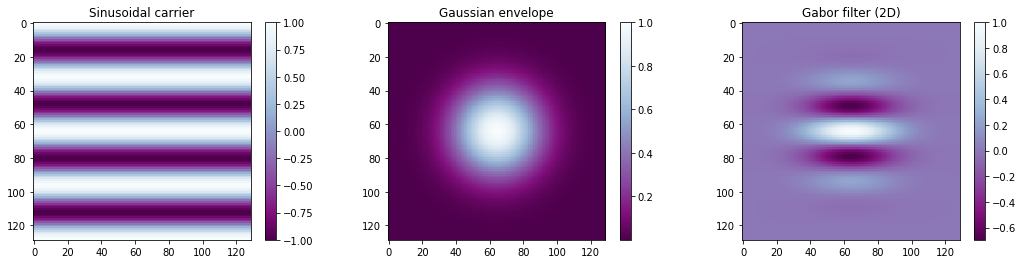

In [10]:

myfig = plt.figure(figsize=(18,4))

y0 = math.floor(PIX_H/2)
x0 = math.floor(PIX_W/2)
y_inputs, x_inputs = np.mgrid[-y0:(y0+1), -x0:(x0+1)]

# Store pixel values (of envelope, carrier, filter) for plotting via imshow.
out_envelope = G2_envelope(x=x_inputs, y=y_inputs,
                             amp=myparas["amp"],
                             sdev=myparas["sdev"])
out_carrier = G2_carrier_real(x=x_inputs,
                              y=y_inputs,
                              freqx=myparas["freqs"]*math.cos(myparas["dir"]),
                              freqy=myparas["freqs"]*math.sin(myparas["dir"]),
                              phase=myparas["phase"])
out_filter = G2_fil_real(x=x_inputs, y=y_inputs, paras=myparas)


ax_carrier = myfig.add_subplot(1,3,1)
plt.title("Sinusoidal carrier")
topass = ax_carrier.imshow(out_carrier, cmap=plt.cm.BuPu_r)
plt.colorbar(topass)

ax_envelope = myfig.add_subplot(1,3,2)
plt.title("Gaussian envelope")
topass = ax_envelope.imshow(out_envelope, cmap=plt.cm.BuPu_r)
plt.colorbar(topass)

ax_filter = myfig.add_subplot(1,3,3)
plt.title("Gabor filter (2D)")
topass = ax_filter.imshow(out_filter, cmap=plt.cm.BuPu_r)
plt.colorbar(topass)

plt.show()



### 練習問題 (C):

0. フィルタの「向き」を制御するパラメータ`dir`（$\theta$に対応）をゼロ、$\pi/4$、$\pi/2$など色々な値にしてみてください。数値を変えることで、フィルタの効能がどう変わると思われるか。

0. 空間周波数パラメータ`freqs`を変えたときに、まず画像全体にわたって何周するか確認してみてください。踏まえて、「ヨコ」方向のみに効くように`dir`を変え、ちょうど5周するように`freqs`も変えること。同様に、10周、25周するように。

0. 直前のコードでは実部（`carrier_real`と`G2_fil_real`）しか使っていない。これらを虚部に変えることで、フィルタの出力がどのように変わるか。

0. 標準偏差のパラメータを調整し、フィルタの有効な半径が（視認できる範囲で）画像幅の半分になるようにすること。同様に、画像幅の1/4、1/8。
___

<a id="2Dapp"></a>
## 2Dフィルタの応用

基礎をおさえた上で、2次元版のガボールフィルタ（空間フィルタ）を応用していこう。画素値そのものが、2次元平面を定義域とする信号の値に相当する。

まずは簡単な応用例から入る。デジタル画像の読み書きを楽にしてくれるライブラリとして、__imageio__ ( http://imageio.github.io/ )が著名である。画像をすでにローカルに保存してることを前提に、次の事例に使う画像を容易に読み込めることを確認しておく。

Shape: (300, 451, 3) Type: <class 'imageio.core.util.Image'> First value (r,g,b): [143 120 104]
Shape: (128, 128, 3) Type: <class 'imageio.core.util.Image'> First value (r,g,b): [180 116  33]
Shape: (633, 801, 3) Type: <class 'imageio.core.util.Image'> First value (r,g,b): [168 165 160]


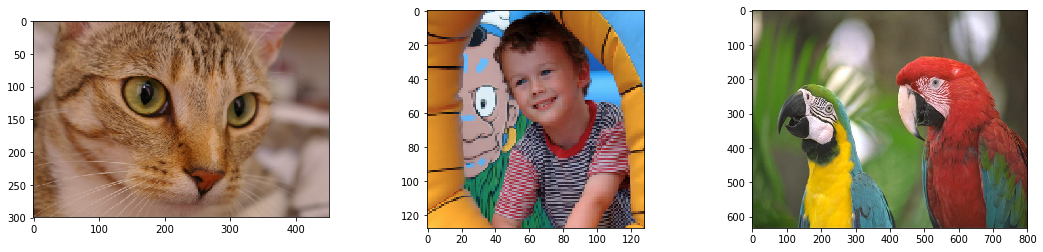

In [11]:
import imageio

# Read images from file.
im_cat = imageio.imread("img/chelsea.png")
im_boy = imageio.imread("img/bishop.png")
im_parrots = imageio.imread("img/parrots.png")

# Inspect (and plot) the images to ensure they have been read as we expect.
print("Shape:", im_cat.shape, "Type:", type(im_cat), "First value (r,g,b):", im_cat[0,0,:])
print("Shape:", im_boy.shape, "Type:", type(im_boy), "First value (r,g,b):", im_boy[0,0,:])
print("Shape:", im_parrots.shape, "Type:", type(im_parrots), "First value (r,g,b):", im_parrots[0,0,:])

myfig = plt.figure(figsize=(18,4))
ax_cat = myfig.add_subplot(1,3,1)
ax_boy = myfig.add_subplot(1,3,2)
ax_parrots = myfig.add_subplot(1,3,3)
ax_cat.imshow(im_cat)
ax_boy.imshow(im_boy)
ax_parrots.imshow(im_parrots)

plt.show()


注目すべきは、imageioが自前の画像オブジェクトを使っていること（`ndarray`型ではない）。その利点は、RGBチャネルがきちんと認識され、カラー画像として表示されることである。

「色」を計算機で表現することは決して自明ではないが、出発点として普通のPNG形式画像のRGBチャネルを取り出していく。

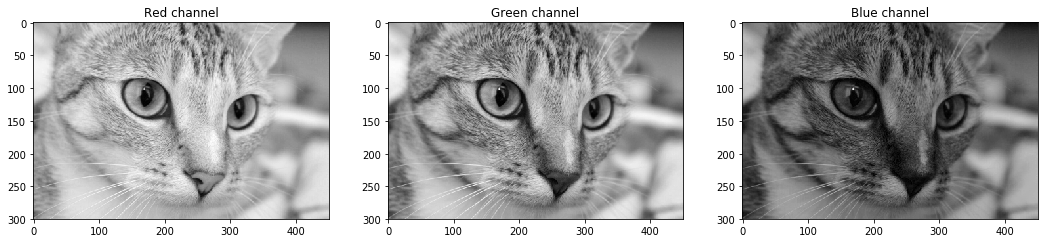

In [12]:

im = imageio.imread("img/chelsea.png")

myfig = plt.figure(figsize=(18,4))
ax_R = myfig.add_subplot(1,3,1)
plt.title("Red channel")
ax_G = myfig.add_subplot(1,3,2)
plt.title("Green channel")
ax_B = myfig.add_subplot(1,3,3)
plt.title("Blue channel")

ax_R.imshow(im[:,:,0], plt.get_cmap('gray'))
ax_G.imshow(im[:,:,1], cmap=plt.get_cmap('gray'))
ax_B.imshow(im[:,:,2], cmap=plt.get_cmap('gray'))
plt.show()


各チャネルの度合い（白いほど高い）はこれで十分わかるが、やや強引にそれらが相当する色に結びつけようと思うと、カラーマップは自由に帰ることができる。

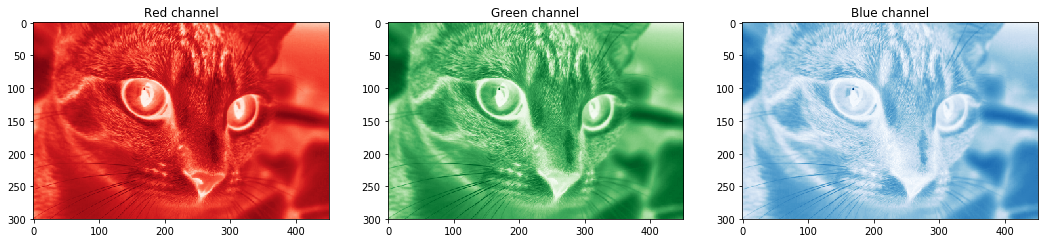

In [13]:

myfig = plt.figure(figsize=(18,4))
ax_R = myfig.add_subplot(1,3,1)
plt.title("Red channel")
ax_G = myfig.add_subplot(1,3,2)
plt.title("Green channel")
ax_B = myfig.add_subplot(1,3,3)
plt.title("Blue channel")

ax_R.imshow(im[:,:,0], cmap=plt.cm.Reds)
ax_G.imshow(im[:,:,1], cmap=plt.cm.Greens)
ax_B.imshow(im[:,:,2], cmap=plt.cm.Blues)
plt.show()


Nishimoto et al. (2011)にしたがって、RGBという色空間から、CIE L\*a\*b\*という別の色空間へと変換し、最終的に使うのはその3チャネルのうち、「L」チャネル、つまり「輝度（luminance）」だけである。

この変換の手助けをしてくれるのが、__scikit-image__ ( http://scikit-image.org/ )である。特に、`color`というモジュールをここで駆使する。

In [14]:
from skimage import color as col

# Re-read the original image from file.
im = imageio.imread("img/chelsea.png")
im_xyz = col.rgb2xyz(im) # convert from RGB to XYZ colour space
im_cielab = col.xyz2lab(im_xyz) # convert from XYZ to CIE L*a*b* colour space.

print("RGB:")
print("Shape:", im.shape, "Type:", type(im), "First value (L*,a*,b*):", im[0,0,:])
print("XYZ:")
print("Shape:", im_xyz.shape, "Type:", type(im_xyz), "First value (X,Y,Z):", im_xyz[0,0,:])
print("L*a*b*:")
print("Shape:", im_cielab.shape, "Type:", type(im_cielab), "First value (L*,a*,b*):", im_cielab[0,0,:])


RGB:
Shape: (300, 451, 3) Type: <class 'imageio.core.util.Image'> First value (L*,a*,b*): [143 120 104]
XYZ:
Shape: (300, 451, 3) Type: <class 'numpy.ndarray'> First value (X,Y,Z): [ 0.20542868  0.20272827  0.15923899]
L*a*b*:
Shape: (300, 451, 3) Type: <class 'numpy.ndarray'> First value (L*,a*,b*): [ 52.14428353   6.33656553  12.11784839]


色表現の変換をすると、データ型が`ndarray`になっているということに注意しながら、「輝度」だけ取り出すことにする。別の言い方をすると、CIE-L\*a\*b\*表現の色情報をすべて捨てることになる。参考として、通常のグレースケール変換（RGBの非一様な平均）と比較する。

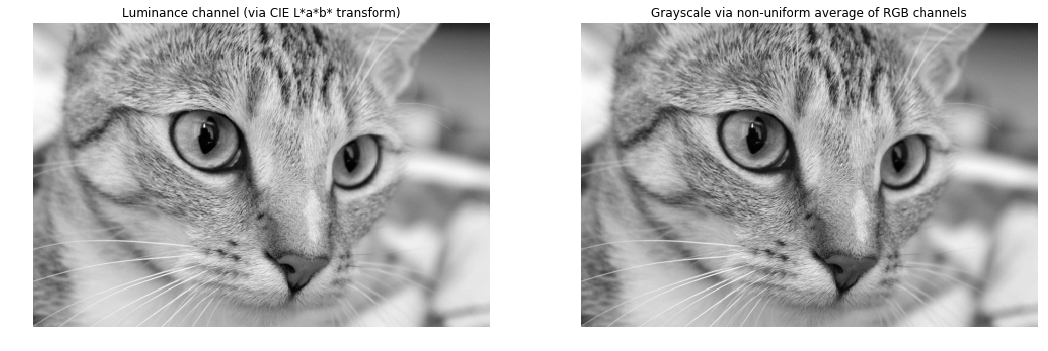

In [15]:

im_L = im_cielab[:,:,0] # the luminance channel of CIE-Lab.
im_gs = col.rgb2gray(im) # the "luminance" by a non-uniform weighted ave of RGB.

myfig = plt.figure(figsize=(18,9))
ax_L = myfig.add_subplot(1,2,1)
plt.title("Luminance channel (via CIE L*a*b* transform)")
plt.axis("off")
ax_gs = myfig.add_subplot(1,2,2)
plt.title("Grayscale via non-uniform average of RGB channels")
plt.axis("off")
ax_L.imshow(im_L, cmap=plt.get_cmap('gray'))
ax_gs.imshow(im_gs, cmap=plt.get_cmap('gray'))

plt.show()


かなり微妙な違いではあるが、上の2枚の画像が互いに異なり、それぞれ特徴を持つことは確かである。また、チャネルが一つしかないので、画像を2次元`ndarray`配列として表現している（これまでは3次元だった）。よって、画像を2次元平面上の信号として見なすことができて、まさしくガボールフィルタを適用する対象物である。

### 練習問題 (D):

0. `img`ディレクトリには、猫の画像（`chelsea.png`）のほかに、男の子（`bishop.png`）やオウム（`parrots.png`）の画像も用意してある。上の一連の操作（チャネルごとに見ること、色空間の変換など）を、猫以外の画像に対しても行うこと。これらの画像をディスクに保存するとき、`imwrite`を使うこと（`imread`の仲間）。

0. 先の問題を踏まえて、3枚のサンプル画像を基に、CIE-Labの輝度チャネルと通常のグレースケール画像を出しているはずである。この2種類の画像それぞれの映りを、異種のハードウエア（別のモニターや隣人のノートPCなど）で確認すること。それぞれの「ハードウエア依存性」らしきものが見られるか。傾向が見られるならば、自分の言葉で説明すること。
___

準備がほぼ整ってきたところである。あとは2次元フィルタを適用するだけである。1次元のケースとまったく同様に、対象信号とフィルタの畳み込みを求めることで「フィルタをかける」ことになる。1次元と違うのは、定義域が2次元平面であることのみ。原理としては1Dでも2Dでも特に変わらないが、計算的にはかなり大変な作業である。自分で実装することは立派だが、今回はそれを敬遠し、__scipy__の__ndimage__モジュールの力を借りることにする。使うのは`convolve`という関数である( https://docs.scipy.org/doc/scipy/reference/ndimage.html )。重要な引数が2つある：

 - `input`： `ndarray`型のオブジェクトで、入力信号に相当する。普通はデジタル画像や動画のフレームなど。
 - `weights`： `ndarray`型のオブジェクトで、フィルタ信号の値である。ここでは2次元ガボールフィルタの値から構成される。画像処理の世界ではよく「カーネル」と呼ばれる。

我々の自作ガボールフィルタが見やすくなるように、これまではその大きさを特に気にせずやってきた。しかし、実務にあたっては、限りなく拡がるガウス関数の範囲を小さくしたほうが圧倒的に効率的である。つまり、掛け合わせる重みがほぼゼロならば、無視して計算時間を省いたほうが賢明、ということである。下記ではこのようなカーネルを造る。

In [16]:

def fil_kernel(paras, n_stds=3):
    '''
    Complex values of 2D Gabor filter, for use in convolution.
    When applied to images, this is typically called
    The linear size of the filter is determined as a multiple
    of the standard deviation of the Gaussian envelope, and the
    values passed to the filter are symmetric about zero.
    
    USAGE: pass the parameters only; the size of the grid of
    response values generated depends on these.
    '''
    
    pixnum = 2*math.ceil(n_stds*paras["sdev"])
    
    y0 = pixnum/2
    x0 = pixnum/2
    y, x = np.mgrid[-y0:(y0+1), -x0:(x0+1)]
    
    # Spatial frequency in polar coordinates.
    u = paras["freqs"] * math.cos(paras["dir"])
    v = paras["freqs"] * math.sin(paras["dir"])
    # Computations.
    envelope = G2_envelope(x=x, y=y,
                           amp=paras["amp"]/(2*math.pi*paras["sdev"]**2),
                           sdev=paras["sdev"])
    out = {"real": None, "imag": None}
    out["real"] = envelope * G2_carrier_real(x=x, y=y, freqx=u, freqy=v, phase=paras["phase"])
    out["imag"] = envelope * G2_carrier_imag(x=x, y=y, freqx=u, freqy=v, phase=paras["phase"])
    
    return out


パラメータはたくさんあり、また文献上ではやり方が実に多様であるから、標準的なカーネルのアウトプットと我々のカーネル（2次元ガボールフィルタそのもの）の出力を比較し、概ね期待するような働きをしているかどうか確認しよう。標準として、scikit-imageの`filters`モジュール（ http://scikit-image.org/docs/dev/api/skimage.filters.html ）の力を拝借し、パラメータを決めて可視化する。

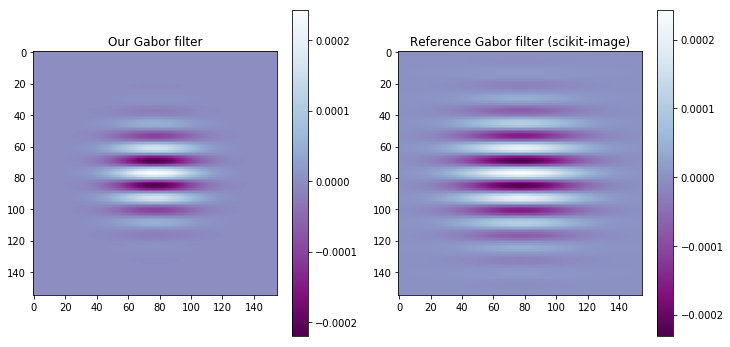

In [17]:
from skimage import filters as skfil

myparas = {"freqs": 8/max(PIX_W,PIX_H),
           "dir": math.pi/2,
           "amp": 1,
           "sdev": max(PIX_W,PIX_H)/5,
           "phase": 0}

ours = fil_kernel(paras=myparas, n_stds=3)

theirs = skfil.gabor_kernel(frequency=myparas["freqs"],
                            theta=myparas["dir"],
                            bandwidth=1,
                            sigma_x=myparas["sdev"],
                            sigma_y=myparas["sdev"],
                            n_stds=3,
                            offset=0)

myfig = plt.figure(figsize=(12,6))

ax_ours = myfig.add_subplot(1,2,1)
plt.title("Our Gabor filter")
topass = ax_ours.imshow(ours["real"], cmap=plt.cm.BuPu_r)
plt.colorbar(topass)

ax_theirs = myfig.add_subplot(1,2,2)
plt.title("Reference Gabor filter (scikit-image)")
topass = ax_theirs.imshow(theirs.real, cmap=plt.cm.BuPu_r)
plt.colorbar(topass)

plt.show()


明らかなように、細部が異なるといえども、粗方合っている。我流の実装が間違っていないと一安心し、作業を続ける。

一定の時間はかかるが、畳み込みをここで実行する。なお、実部と虚部で2つのフィルタがあるため、同じ画像と2回畳み込むことになる。

In [18]:
from scipy import ndimage as ndi

im = imageio.imread("img/chelsea.png")
im_L = col.xyz2lab(col.rgb2xyz(im))[:,:,0]
PIX_H = im_L.shape[0]
PIX_W = im_L.shape[1]

myparas = {"freqs": 32/max(PIX_W,PIX_H),
           "dir": math.pi/2,
           "amp": 0.1,
           "sdev": max(PIX_W,PIX_H)/20,
           "phase": 0}
mymode = "reflect"
mycval = 0

fil_values = fil_kernel(paras=myparas, n_stds=3)

print("Convolving w/ real part (takes time)...", end=" ")
fil_response_real = ndi.convolve(input=im_L, weights=fil_values["real"], mode=mymode, cval=mycval)
print("OK.")
print("Convolving w/ imaginary part (takes time)...", end=" ")
fil_response_imag = ndi.convolve(input=im_L, weights=fil_values["imag"], mode=mymode, cval=mycval)
print("OK.")



Convolving w/ real part (takes time)... OK.
Convolving w/ imaginary part (takes time)... OK.


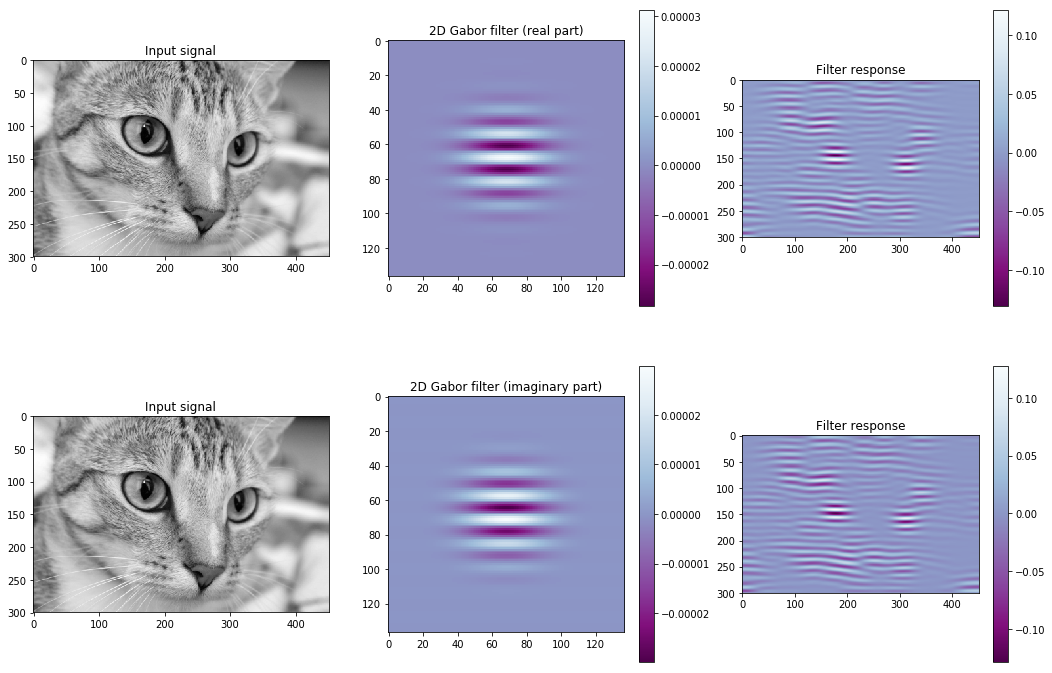

In [19]:

myfig = plt.figure(figsize=(18,12))

ax_signal = myfig.add_subplot(2,3,1)
plt.title("Input signal")
ax_signal.imshow(im_L, cmap=plt.get_cmap('gray'))

ax_filter = myfig.add_subplot(2,3,2)
plt.title("2D Gabor filter (real part)")
topass = ax_filter.imshow(fil_values["real"], cmap=plt.cm.BuPu_r)
plt.colorbar(topass)

ax_response = myfig.add_subplot(2,3,3)
plt.title("Filter response")
topass = ax_response.imshow(fil_response_real, cmap=plt.cm.BuPu_r)
plt.colorbar(topass)

ax_signal = myfig.add_subplot(2,3,4)
plt.title("Input signal")
ax_signal.imshow(im_L, cmap=plt.get_cmap('gray'))

ax_filter = myfig.add_subplot(2,3,5)
plt.title("2D Gabor filter (imaginary part)")
topass = ax_filter.imshow(fil_values["imag"], cmap=plt.cm.BuPu_r)
plt.colorbar(topass)

ax_response = myfig.add_subplot(2,3,6)
plt.title("Filter response")
topass = ax_response.imshow(fil_response_imag, cmap=plt.cm.BuPu_r)
plt.colorbar(topass)

plt.show()


畳み込む作業が完了すれば、特徴量を造る準備が整った。フィルタをかけた結果の全画素を使うことは原理的には可能だが、冗長性が高く、計算的な制約もあるため、一部の情報を捨てて、コンパクトな特徴量を求める。やり方としては、$I$（平面上から画素値への写像$(x,y) \mapsto I(x,y) \in \mathbb{R}$）を所与として、我々のガボールフィルタ（同様な写像$(x,y) \mapsto F(x,y) \in \mathbb{C}$）をかけて、

\begin{align}
\widetilde{I}(x,y) = (I \ast F)(x,y) \in \mathbb{C}, \quad (x,y) \in \mathbb{R}^{2}
\end{align}

という新しい信号が求まった（先ほどの右図）。まずは実部と虚部のを融合させて、フィルタ全体として強く応答している領域を明らかにしよう。これは複素数のノルム$|\widetilde{I}(x,y)|$（ここで$|z| = \sqrt{\text{Re}(z)^{2} + \text{Im}(z)^{2}}$と定義）で測定することができる。解釈としては、この量が大きい領域こそが「特徴的」であるという。計算し、可視化していくと、下記のとおりになる。

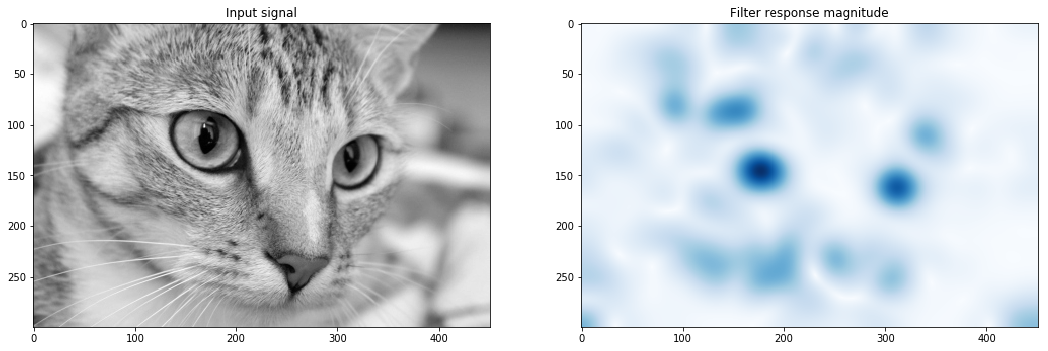

In [20]:

# Magnitude of the complex filter response.
fil_response_magnitude = np.sqrt((fil_response_real**2+fil_response_imag**2))

myfig = plt.figure(figsize=(18,12))

ax_signal = myfig.add_subplot(1,2,1)
plt.title("Input signal")
ax_signal.imshow(im_L, cmap=plt.get_cmap('gray'))

ax_filter = myfig.add_subplot(1,2,2)
plt.title("Filter response magnitude")
ax_filter.imshow(fil_response_magnitude, cmap=plt.cm.Blues)

plt.show()


### 練習問題 (E):

0. 何よりも把握したいのは、フィルタのパラメータが畳み込みの結果に対してどのような影響を及ぼすかということである。特に重要なのは、`dir`、`freqs`、`stdev`、`n_stds`と4つである。いずれも極端な値に設定してフィルタをかけてみること。結果がどのように変わるか。その変化は、パラメータの「及ぼすであろう」という予想と、ほぼ合っているか。直感に反するようなことがあれば、それも併せて説明すること。

0. 先の練習問題に続き、このパラメータ微調整を、猫の画像のみならず、`chelsea.png`、`bishop.png`、`parrots.png`の3つに対して行うこと。画像の中身によっては、特徴たるものが異なることは当然だが、やはりそれをきちんと「拾う」ためには、それぞれ異なるパラメータ設定が必要になるか。
___

個々の画素をすべて見るのではなく、特徴的な「領域」さえ把握できれば十分であるから、画素の部分集合（パッチ）ごとにいくつかの統計量を計算し、各領域の代表値を叩き出す。もう少し厳密にいえば、画像$I$を互いに素（mutally disjoint）なパッチに分割し、$\{I_{1},\ldots,I_{k}\}$と書く。すると、$i$番目のパッチの応答$\widetilde{r}_{i}$として、たとえば

\begin{align}
\widetilde{r}_{i} = \frac{1}{|\text{dom}(I_{i})|} \sum_{(a,b) \in \text{dom}(I_{i})} |I_{i}(a,b)|,
\end{align}

を使うことが自然である（$i=1,\ldots,k$）。算術平均のみならず、中央値、最大値、最小値など、いろいろな統計量を考えることができる。応答$\widetilde{r}_{i}$を求めた後、非線形な関数に渡して、その値を圧縮してから最終的な特徴量を打ち出す。式で表すと、

\begin{align}
r_{i} = \log(1+\widetilde{r}_{i}).
\end{align}

で定義される$r_{i}$が特定のフィルタと特定のパッチに対応する特徴量である。

パッチごとの統計量を求める作業と非線形圧縮の作業は下記のように実装する。

In [21]:

def patch_stats(image, grid_w, grid_h):
    '''
    A simple function which takes an image, divides it
    into a (grid_y x grid_x) grid of patches, and iterates
    over the patches, computing per-patch statistics.
    
    In the special case of grid_x=grid_y=1, stats are for the whole image.
    '''
    
    pix_h = image.shape[0] # number of pixels
    pix_w = image.shape[1]
    
    gridsize = grid_w*grid_h
    
    dh = math.floor(pix_h/grid_h) # typical (non-edge) patch sizes
    dw = math.floor(pix_w/grid_w)
    
    meanvec = np.zeros(gridsize, dtype=np.float32) # initialize vectors to hold the stats
    medvec = np.zeros(gridsize, dtype=np.float32)
    maxvec = np.zeros(gridsize, dtype=np.float32)
    minvec = np.zeros(gridsize, dtype=np.float32)
    
    # Loop over the patches, starting at the top-left, and doing one grid row at a time.
    idx = 0
    for i in range(grid_h):
        
        start_h = i * dh
        if (i+1 == grid_h):
            stop_h = pix_h
        else:
            stop_h = start_h + dh
        
        for j in range(grid_w):
            
            start_w = j * dw
            if (j+1 == grid_w):
                stop_w = pix_w
            else:
                stop_w = start_w + dw
            
            patch = image[start_h:stop_h, start_w:stop_w]
            meanvec[idx] = np.mean(patch) # patch mean
            medvec[idx] = np.median(patch) # patch median
            maxvec[idx] = np.max(patch) # patch maximum
            minvec[idx] = np.min(patch) # patch minimum
            idx += 1
    
    return {"mean": meanvec, "med": medvec, "max": maxvec, "min": minvec}


def nonlin(u):
    '''
    A non-linear function to pass per-patch magnitude statistics through.
    '''
    
    return np.log(1+u)


中身を軽く解説すると：

 - `patch_stats`： 画像を分割したグリッドの寸法（ヨコ、タテ）を与えられたとき、逐次的にパッチを追って、統計量を計算してまとめる関数。
 
 - `nonlin`： 特徴の度合いを表す生の数値を圧縮するための非線形関数。

パッチごとの統計量が予想どおりであるかどうか確認してみよう。

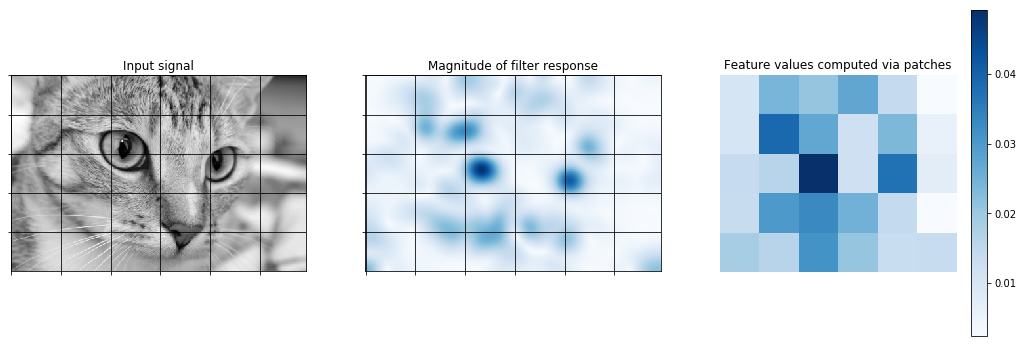

In [22]:
mygrid_h = 5
mygrid_w = 6

# Compute per-patch statistics.
mystats = patch_stats(image=fil_response_magnitude,
                      grid_h=mygrid_h, grid_w=mygrid_w)

# Pass the per-patch magnitude statistics through a non-linear function,
# and arrange into a matrix such that correspondence between feature
# values and sub-regions of the image is clear.
features = nonlin(mystats["mean"]).reshape((mygrid_h,mygrid_w))

myfig = plt.figure(figsize=(18,6))

ax_signal = myfig.add_subplot(1,3,1)
plt.title("Input signal")
ax_signal.set_xticks(np.arange(0, PIX_W, math.ceil(PIX_W/mygrid_w)))
ax_signal.set_yticks(np.arange(0, PIX_H, math.ceil(PIX_H/mygrid_h)))
ax_signal.grid(linestyle="-", color='black')
ax_signal.set_yticklabels([])
ax_signal.set_xticklabels([])
ax_signal.imshow(im_L, cmap=plt.get_cmap('gray'))

ax_filter = myfig.add_subplot(1,3,2)
plt.title("Magnitude of filter response")
ax_filter.set_xticks(np.arange(0, PIX_W, math.ceil(PIX_W/mygrid_w)))
ax_filter.set_yticks(np.arange(0, PIX_H, math.ceil(PIX_H/mygrid_h)))
ax_filter.grid(linestyle="-", color='black')
ax_filter.set_yticklabels([])
ax_filter.set_xticklabels([])
ax_filter.imshow(fil_response_magnitude, cmap=plt.cm.Blues)

ax_features = myfig.add_subplot(1,3,3)
plt.title("Feature values computed via patches")
topass = ax_features.imshow(features, cmap=plt.cm.Blues)
ax_features.axis("off")
myfig.colorbar(topass)
plt.show()



ここで念のために強調しておきたい点がある。機械学習の「学習課題」を見据えて、学習機が正確にどのような事例を与えられるかは、どうしても知ることができない（できるのであれば、学習の必要性はほぼない）。当たり前のことではあるが、含意として、特徴量を拾うためのフィルタの「ちょうど良い設定」を事前に済ませることなど考えられない。このことから、たくさんのフィルタを事前に用意し、多種多様な特徴量を取るための準備を全うするしかない。これが従来の特徴量づくりである。

### 練習問題 (F):

0. 標準偏差パラメータ`sdev`を大きく・小さくすることで、フィルタをかけた結果が変わりうることはすでに確認しているはずである。この事実を踏まえて、`sdev`の大小を考慮し、どのようにパッチの大きさ（つまりグリッドのサイズ）を設定すべきと考えるか。解像度の高い・低いグリッドをそれぞれ作り、その有用性について説明すること（端的にいえば、反応してほしいところが反応しているのかどうか）。

0. 先の練習問題で行った作業を、`chelsea.png`、`bishop.png`、`parrots.png`の3つの画像に対して行うこと。元の画像の特性によって「良い設定」がそれぞれ異なると思われるが、実験してみてどのように考えるか説明すること。


結びとして、デジタル画像が多い場合や、多数のフレームから成る動画像を扱っている場合、上の作業を繰り返して行なう関数はいうまでもなく作っておくべきである。下記の通りに、その「全工程」を担う関数を設計する。

In [23]:

def G2_getfeatures(ims, fil_paras, gridshape, mode="reflect", cval=0):
    '''
    A routine which takes an array of images with 4 coords.
    Dim 1 and 2: pixel position.
    Dim 3: RGB channel index.
    Dim 4: Time index.
    '''
    
    num_ims = ims.shape[3]
    num_feats = gridshape[0] * gridshape[1]
    
    out = np.zeros(num_ims*num_feats, dtype=np.float32).reshape((num_ims,num_feats))
    
    # Generate the kernel prior to loop over images.
    fil_values = fil_kernel(paras=fil_paras, n_stds=2)
    
    # Iterate over images.
    for i in range(num_ims):
        
        featvec = np.arange(0, dtype=np.float32)
        
        # Slice -> XYZ -> CIE Lab -> Take only Luminance channel.
        im = col.xyz2lab(col.rgb2xyz(ims[:,:,:,i]))[:,:,0]
        
        # Convolution.
        fil_response_real = ndi.convolve(input=im,
                                         weights=fil_values["real"],
                                         mode=mode, cval=cval)
        fil_response_imag = ndi.convolve(input=im,
                                         weights=fil_values["imag"],
                                         mode=mode, cval=cval)
        fil_response_magnitude = np.sqrt((fil_response_real**2 + fil_response_imag**2))
        
        # Per-patch statistics.
        imstats = patch_stats(image=fil_response_magnitude, grid_h=gridshape[0], grid_w=gridshape[1])
            
        # Pass per-patch statistics through non-linearity to compute final feature vector.
        imfeats = nonlin(imstats["mean"])
        
        # Store the feature vector for this image.
        out[i,:] = imfeats
    
    # Output is the array of feature vectors, one feature vector for each image.
    return out


### 練習問題 (G):

0. 先ほど用意した関数`G2_getfeatures`を何度か使い、正真正銘のフィルタ「バンク」を造ること。やり方は単純で、複数のdict（`fil_paras`として渡すもの）を予め作り、個別に`G2_getfeatures`に渡すことである。同じ画像に対してdictの個数だけのベクトルを得ることになるが、それらを連結して（concatenate）、特徴量ベクトルとして一本の長いベクトルを求める。

0. フィルタのパラメータはもちろんだが、そのほかに各パッチの数値を基に計算される統計量の選択も重要である。平均以外の統計量を使うと、結果がどのように変わるか。また、予測課題を見据えて、どれが有用だと思われるか。あまり有用でないのはどれか。その理由も合わせて説明すること。


### 終わり： 後に使う関数などを`scripts/FilterBank.py`に貼り付けること。

## 参考文献：

 - Adelson, Edward H., and James R. Bergen. "Spatiotemporal energy models for the perception of motion." JOSA A 2.2 (1985): 284-299.
 - DeAngelis, Gregory C., Izumi Ohzawa, and R. D. Freeman. "Spatiotemporal organization of simple-cell receptive fields in the cat's striate cortex. I. General characteristics and postnatal development." Journal of neurophysiology 69.4 (1993): 1091-1117.
 - Heeger, David J. "Optical flow using spatiotemporal filters." International journal of computer vision 1.4 (1988): 279-302.
 - Jones, Judson P., and Larry A. Palmer. "An evaluation of the two-dimensional Gabor filter model of simple receptive fields in cat striate cortex." Journal of neurophysiology 58.6 (1987): 1233-1258.
 - Watson, Andrew B., and Albert J. Ahumada. "Model of human visual-motion sensing." JOSA A 2.2 (1985): 322-342.
 - Nishimoto, Shinji, et al. "Reconstructing visual experiences from brain activity evoked by natural movies." Current Biology 21.19 (2011): 1641-1646.
 - Texture classification reference: http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_gabor.html
 - Facial recognition reference: Brain-like Integrated Systems Lab, Department of Human Intelligence Systems, Graduate School of Life Science and Systems Engineering, Kyushu Institute of Technology. URL: http://www.brain.kyutech.ac.jp/~morie/topics/gabor_en.shtml

## その他：

In [24]:

## Frequency response of the Gabor filter is obtained analytically as the (complex) Fourier transform.
def G_ft_real(f, amp, sdev, freq, phase):
    '''
    Real part of the complex Gabor filter's frequency response.
    '''
    topass = (f - freq) * sdev
    env = G_envelope(t=topass, amp=1, sdev=1)
    out = math.cos(phase) * amp * sdev * env
    return out

def G_ft_imag(f, amp, sdev, freq, phase):
    '''
    Imaginary part of the complex Gabor filter's frequency response.
    '''
    topass = (f - freq) * sdev
    env = G_envelope(t=topass, amp=1, sdev=1)
    out = math.sin(phase) * amp * sdev * env
    return out


def G_fr_real(f, paras):
    '''
    Frequency response for our custom-built filter (real part).
    Assumes that f is an array of frequency settings.
    '''
    out = G_ft_real(f=f, amp=paras["amp"], sdev=paras["sdev"], freq=paras["freq"], phase=paras["phase"])
    return out

def G_fr_imag(f, paras):
    '''
    Frequency response for our custom-built filter (real part).
    Assumes that f is an array of frequency settings.
    '''
    out = G_ft_imag(f=f, amp=paras["amp"], sdev=paras["sdev"], freq=paras["freq"], phase=paras["phase"])
    return out


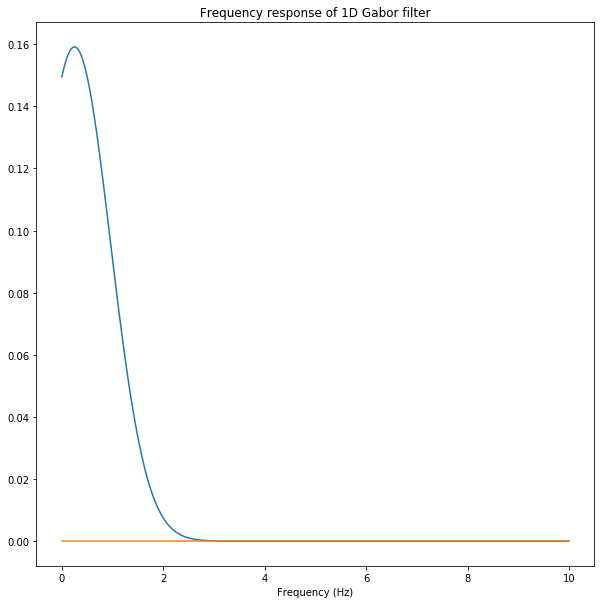

In [25]:

myparas = {"amp": 1/(2*math.pi),
           "sdev": 1,
           "freq": 0.25,
           "phase": 0}

f_inputs = np.linspace(0,10,500)

myfig = plt.figure(figsize=(10,10))
plt.plot(f_inputs, G_fr_real(f=f_inputs, paras=myparas))
plt.plot(f_inputs, G_fr_imag(f=f_inputs, paras=myparas))
plt.title("Frequency response of 1D Gabor filter")
plt.xlabel("Frequency (Hz)")
plt.show()
